# Spacy vectorization model notebook

In [1]:
import logging
from gensim.models import word2vec

import sys
import os
        
from src import data_prepare
from src import feature_extraction

import gzip
from gensim.models import word2vec

from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt

import spacy
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

post, thread=data_prepare.load_train_data()
post_test, thread_test=data_prepare.load_test_data()
label_map=data_prepare.load_label_map()

In [3]:
train_data_to_clean=[]
test_data_to_clean=[]

train_data_to_clean=data_prepare.get_all_text_data_from_posts(post,thread)
test_data_to_clean=data_prepare.get_all_text_data_from_posts(post_test,thread_test)

###  I used standard spacy english model, larger models showed no major improvements, only memory consumption

In [4]:
nlp = spacy.load('en', disable=['ner', 'parser'])

In [5]:
def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(txt)
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in train_data_to_clean)
brief_cleaning_test = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in test_data_to_clean)

In [ ]:
train_txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=20, n_threads=-1)]

In [ ]:
test_txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning_test, batch_size=20, n_threads=-1)]

In [8]:
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in txt]
phrases = Phrases(sent, min_count=5, progress_per=1000)
bigram = Phraser(phrases)
sentences = bigram[sent]

2019-02-15 17:10:27,022 : INFO : collecting all words and their counts
2019-02-15 17:10:27,024 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-02-15 17:10:31,628 : INFO : collected 968684 word types from a corpus of 2670549 words (unigram + bigrams) and 358 sentences
2019-02-15 17:10:31,630 : INFO : using 968684 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2019-02-15 17:10:31,664 : INFO : source_vocab length 968684
2019-02-15 17:10:41,069 : INFO : Phraser built with 6709 6709 phrasegrams


In [9]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

50236

In [10]:
sorted(word_freq, key=word_freq.get, reverse=True)[:12]

['be',
 'not',
 'quote_section',
 'scum',
 'vote',
 'game',
 'think',
 'town',
 'lynch',
 'post']

## Feed the vocabulary of the dataset to genism just for fun

In [12]:
import multiprocessing
from gensim.models import Word2Vec
cores = multiprocessing.cpu_count()


w2v_model = Word2Vec(min_count=10, window=2,size=300,
                     sample=6e-5, alpha=0.03, min_alpha=0.0007,
                     negative=20,workers=cores-1)

w2v_model.build_vocab(sentences, progress_per=100)

2019-02-15 17:12:58,012 : INFO : collecting all words and their counts
2019-02-15 17:12:58,226 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-02-15 17:13:04,664 : INFO : collected 50236 word types from a corpus of 2453579 raw words and 358 sentences
2019-02-15 17:13:04,666 : INFO : Loading a fresh vocabulary
2019-02-15 17:13:04,707 : INFO : min_count=10 retains 11705 unique words (23% of original 50236, drops 38531)
2019-02-15 17:13:04,709 : INFO : min_count=10 leaves 2362430 word corpus (96% of original 2453579, drops 91149)
2019-02-15 17:13:04,758 : INFO : deleting the raw counts dictionary of 50236 items
2019-02-15 17:13:04,762 : INFO : sample=6e-05 downsamples 909 most-common words
2019-02-15 17:13:04,763 : INFO : downsampling leaves estimated 1057625 word corpus (44.8% of prior 2362430)
2019-02-15 17:13:04,800 : INFO : estimated required memory for 11705 words and 300 dimensions: 33944500 bytes
2019-02-15 17:13:04,801 : INFO : resetting layer weigh

In [13]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=15, report_delay=1)

2019-02-15 17:13:45,115 : INFO : training model with 3 workers on 11705 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
2019-02-15 17:13:46,325 : INFO : EPOCH 1 - PROGRESS: at 4.75% examples, 75652 words/s, in_qsize 0, out_qsize 0
2019-02-15 17:13:47,377 : INFO : EPOCH 1 - PROGRESS: at 15.08% examples, 93243 words/s, in_qsize 0, out_qsize 0
2019-02-15 17:13:48,418 : INFO : EPOCH 1 - PROGRESS: at 25.42% examples, 102449 words/s, in_qsize 2, out_qsize 0
2019-02-15 17:13:49,466 : INFO : EPOCH 1 - PROGRESS: at 40.50% examples, 111041 words/s, in_qsize 2, out_qsize 0
2019-02-15 17:13:50,496 : INFO : EPOCH 1 - PROGRESS: at 53.35% examples, 114031 words/s, in_qsize 0, out_qsize 0
2019-02-15 17:13:51,512 : INFO : EPOCH 1 - PROGRESS: at 70.95% examples, 116142 words/s, in_qsize 1, out_qsize 0
2019-02-15 17:13:52,536 : INFO : EPOCH 1 - PROGRESS: at 93.58% examples, 118466 words/s, in_qsize 0, out_qsize 2
2019-02-15 17:13:52,928 : INFO : worker thread finished; awai

2019-02-15 17:15:32,126 : INFO : EPOCH 14 - PROGRESS: at 24.30% examples, 92520 words/s, in_qsize 2, out_qsize 1
2019-02-15 17:15:33,175 : INFO : EPOCH 14 - PROGRESS: at 37.99% examples, 102348 words/s, in_qsize 4, out_qsize 1
2019-02-15 17:15:34,235 : INFO : EPOCH 14 - PROGRESS: at 50.28% examples, 102235 words/s, in_qsize 5, out_qsize 0
2019-02-15 17:15:35,272 : INFO : EPOCH 14 - PROGRESS: at 65.92% examples, 105226 words/s, in_qsize 6, out_qsize 0
2019-02-15 17:15:36,289 : INFO : EPOCH 14 - PROGRESS: at 89.39% examples, 111556 words/s, in_qsize 5, out_qsize 0
2019-02-15 17:15:36,937 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-15 17:15:36,942 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-15 17:15:36,947 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-02-15 17:15:36,947 : INFO : EPOCH - 14 : training on 2453579 raw words (930239 effective words) took 8.0s, 115741 effective words/s
2019-02-15 17:15:37,9

(13949841, 36803685)

In [14]:
w2v_model.init_sims(replace=True)

2019-02-15 17:16:15,674 : INFO : precomputing L2-norms of word weight vectors


In [15]:
w2v_model.wv.most_similar(positive=["lynch"])

[('lynched', 0.7282142639160156),
 ('nolynch', 0.7224632501602173),
 ('mislynch_lose', 0.7174205780029297),
 ('flip_coin', 0.7150850296020508),
 ('save_ass', 0.6951632499694824),
 ('nl', 0.6912053227424622),
 ('liability', 0.6900382041931152),
 ('mislynch', 0.6875871419906616),
 ('break_tie', 0.6855727434158325),
 ('untie', 0.6846047043800354)]

In [16]:
w2v_model.wv.most_similar(positive=["town", "doctor"], negative=["mafia"], topn=6)

[('doctor_protection', 0.6068865060806274),
 ('protector', 0.5865193009376526),
 ('expose', 0.5542176961898804),
 ('protect', 0.5540183186531067),
 ('protectee', 0.5504580736160278),
 ('die_tonight', 0.549311637878418)]

In [17]:
w2v_model.wv.doesnt_match(['mafia', 'town', 'lynch','paper'])

'paper'

In [25]:
w2v_model.wv.similarity("vote", 'lynch')

0.5785817095297348

## Finally vectorizing with spacy

In [8]:
train_data_features=[nlp(item).vector for item in train_txt]

In [12]:
test_data_features=[nlp(item).vector for item in test_txt]

In [13]:
train_data_features=np.array(train_data_features)
test_data_features=np.array(test_data_features)

In [17]:
train_data_features=feature_extraction.get_features(post, thread, train_data_features)
test_data_features=feature_extraction.get_features(post_test, thread_test, test_data_features)

In [18]:
X_test=test_data_features
X_train=train_data_features
y_train=thread["thread_label_id"]
#X_train, X_val, y_train, y_val = train_test_split(train_data_features, thread["thread_label_id"], test_size=0.15, random_state=96)

In [115]:
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
tr_pred=model.predict(X_train)
y_full=model.predict(train_data_features)


print("Accuracy on val dataset: {:.2f}".format((accuracy_score(y_pred, y_val))*100))
print("Accuracy on train dataset: {:.2f}".format((accuracy_score(tr_pred, y_train))*100))
print("Accuracy on train full: {:.2f}".format((accuracy_score(y_full, thread["thread_label_id"]))*100))

Accuracy on val dataset: 66.67
Accuracy on train dataset: 78.29
Accuracy on train full: 76.54


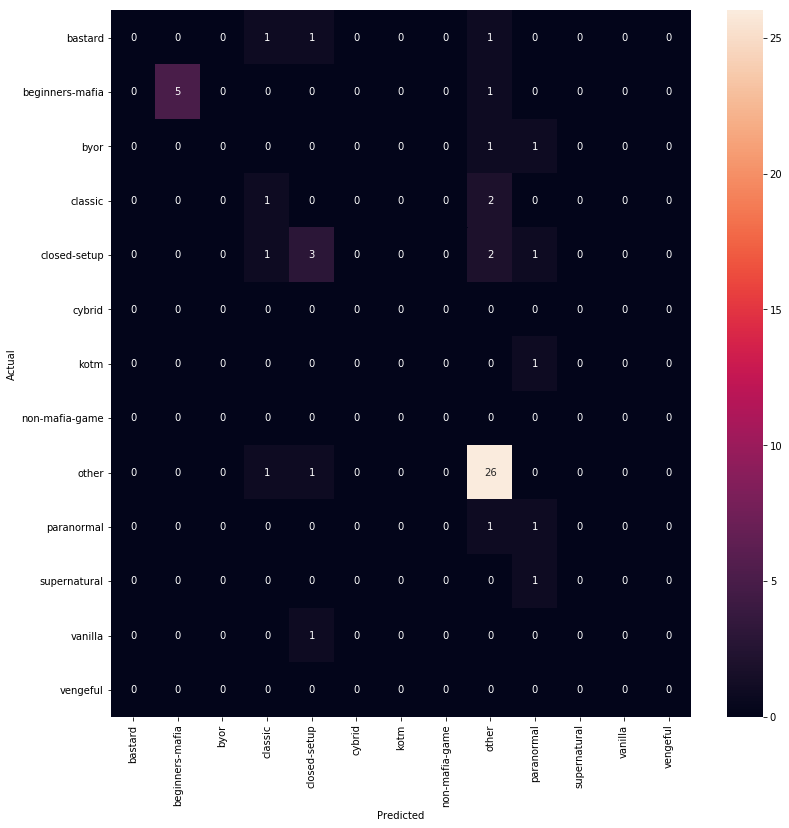

In [116]:
conf_mat = confusion_matrix(y_val, y_pred,labels=label_map["type_id"].values)
fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=label_map.index, yticklabels=label_map.index)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [124]:
new_full=opt(thread, y_full)

print("Accuracy on optimized: {:.2f}".format((accuracy_score(new_full, thread["thread_label_id"]))*100))

Accuracy on optimized: 77.93


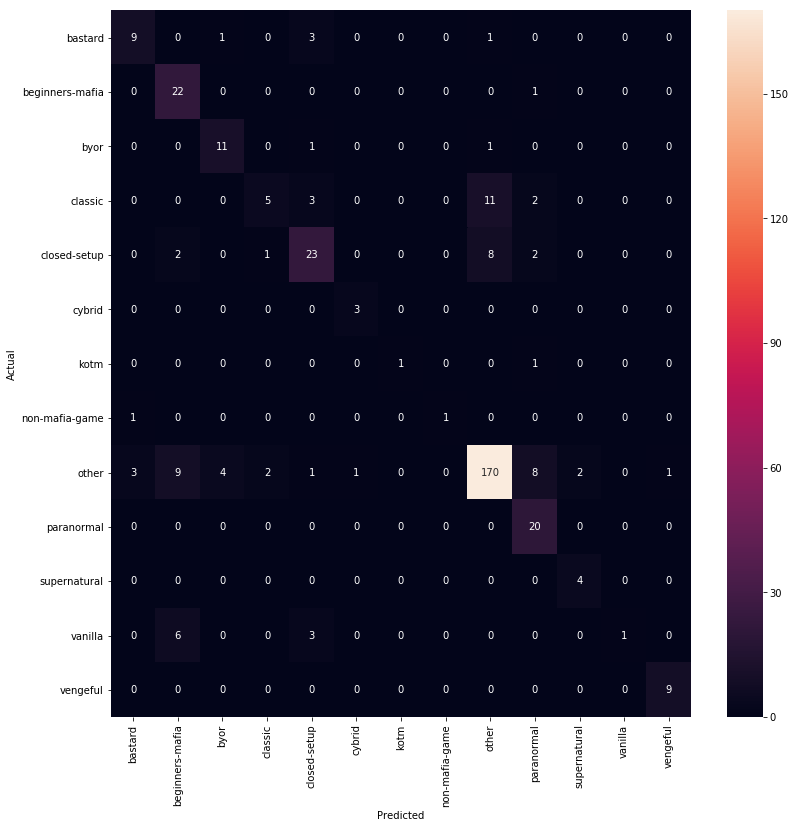

In [121]:
conf_mat = confusion_matrix(thread["thread_label_id"], new_full,labels=label_map["type_id"].values)
fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=label_map.index, yticklabels=label_map.index)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Some notes:

- Spacy vectorization did improve performance on the haredest class: cybrid
- Test accuracy: 64.4

In [33]:
lab=pd.Series(train_predict)
ans = pd.concat([thread_test["thread_num"],lab], axis=1, keys=['thread_num', 'thread_label_id'])
ans=ans.set_index("thread_num")
ans.head()

,thread_label_id
thread_num,
126856,8
132415,8
134482,8
133728,1
134270,8


In [36]:
path=os.path.join(module_path,"submissions")
ans.to_csv(os.path.join(path,"sol34.csv"))